#Install Dependencies
may take a while...

In [1]:
%%capture
!pip install -q transformers pdf2image colorama PyMuPDF
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.6'

In [2]:
!sudo apt-get install tesseract-ocr-eng tesseract-ocr-deu poppler-utils
!pip install -q pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr tesseract-ocr-osd
The following NEW packages will be installed:
  poppler-utils tesseract-ocr tesseract-ocr-deu tesseract-ocr-eng
  tesseract-ocr-osd
0 upgraded, 5 newly installed, 0 to remove and 9 not upgraded.
Need to get 5,746 kB of archives.
After this operation, 17.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.1 [186 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesse

##$\color{red}{\text{CAUTION!}}$
Runtime restart necessary after installing tesseract. Resume here afterwards.


---




Login if hosted in a private repository.

In [3]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


#Imports

In [4]:
import torch
from PIL import Image, ImageDraw, ImageFont
import requests
from io import BytesIO
from pdf2image import convert_from_path, convert_from_bytes
import numpy as np
import fitz
from transformers import AutoModelForTokenClassification, LayoutLMv2FeatureExtractor, LayoutXLMTokenizerFast, LayoutXLMProcessor, AutoTokenizer, pipeline
from tokenizers.pre_tokenizers import Whitespace, Split, Sequence
from transformers.models.xlm_roberta import XLMRobertaTokenizerFast

In [5]:
model = AutoModelForTokenClassification.from_pretrained("GEOcite/DocumentSegmentationModel")
feature_extractor = LayoutLMv2FeatureExtractor(apply_ocr=True, ocr_lang='deu')
tokenizer = LayoutXLMTokenizerFast.from_pretrained("GEOcite/DocumentSegmentationModel")
processor = LayoutXLMProcessor(feature_extractor, tokenizer)

/usr/local/lib/python3.10/dist-packages/transformers/models/layoutlmv2/feature_extraction_layoutlmv2.py:30: FutureWarning: The class LayoutLMv2FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv2ImageProcessor instead.
  warnings.warn(


In [ ]:
#ws_tk = Whitespace()
#s_tk = Split(".", "isolated")
#sequence = Sequence([ws_tk])

tokenizer_refseg = XLMRobertaTokenizerFast.from_pretrained("GEOcite/ReferenceParserModel")
#tokenizer_refseg.pre_tokenizer = sequence

classifier = pipeline(model="GEOcite/ReferenceParserModel", tokenizer=tokenizer_refseg, trust_remote_code=True)

A new version of the following files was downloaded from https://huggingface.co/MrPotato/GeociteReferenceSegmentation:
- configuration_refseg.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


A new version of the following files was downloaded from https://huggingface.co/MrPotato/GeociteReferenceSegmentation:
- ref_seg.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


A new version of the following files was downloaded from https://huggingface.co/MrPotato/GeociteReferenceSegmentation:
- modeling_refseg.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


ValueError: ignored

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

LayoutLMv2ForTokenClassification(
  (layoutlmv2): LayoutLMv2Model(
    (embeddings): LayoutLMv2Embeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (visual): LayoutLMv2VisualBackbone(
      (backbone): FPN(
        (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
        (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [7]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

def normalize_box(box, width, height):
    return [
        int(1000 * (box[0] / width)),
        int(1000 * (box[1] / height)),
        int(1000 * (box[2] / width)),
        int(1000 * (box[3] / height)),
    ]

def iob_to_label(label):
    if not label:
      return 'other'
    return label

In [18]:
#working
#path_sample = 'http://hyperion.bbirke.de/data/geocite/pdfs/EuRe_1994_0003.pdf'

#no refs, authors messy
#path_sample = 'http://hyperion.bbirke.de/data/geocite/pdfs/RaRa_1999_014.pdf'

#authors not detected, title messy, references good
#path_sample = 'http://hyperion.bbirke.de/data/geocite/pdfs/Raum_1996_0003.pdf'

#working
#path_sample = 'http://hyperion.bbirke.de/data/geocite/pdfs/ZTou_2010_0012.pdf'

#

#path_sample = 'http://hyperion.bbirke.de/data/geocite/pdf_unseen/Unsinn_und_Sinn_des_Regionalis.pdf'
#path_sample = 'http://hyperion.bbirke.de/data/geocite/pdf_unseen/geomorphological-westeastsection-through-the-north-chilean-andes.pdf'
#path_sample = 'http://hyperion.bbirke.de/data/geocite/pdf_unseen/lohnert2005.pdf'
#path_sample = 'http://hyperion.bbirke.de/data/geocite/pdf_unseen/Ambivalente_Reprasentationen_Betrachtung.pdf'
path_sample = 'https://hyperion.bbirke.de/data/geocite/pdf_unseen/festival.pdf'
#path_sample = 'http://hyperion.bbirke.de/data/geocite/pdf_unseen/PXL_20230109_120304928.pdf'
#path_sample = "https://github.com/exciteproject/EXgoldstandard/raw/master/Goldstandard_EXparser/1-German_papers/1-German_papers(with_reference_section_at_end_of_paper)/1-pdfs/50111.pdf"

#path_sample = "https://arxiv.org/ftp/arxiv/papers/1207/1207.4157.pdf"

response = requests.get(path_sample)

doc = fitz.open("pdf", response.content) # open document
dpi = 400  # choose desired dpi here
zoom = dpi / 72  # zoom factor, standard: 72 dpi
magnify = fitz.Matrix(zoom, zoom)  # magnifies in x, resp. y direction
images = []
#skip = range(13, 15)
for i, page in enumerate(doc):
    # if i not in skip:
    #    continue
    pix = page.get_pixmap(matrix=magnify)  # render page to an image
    img = Image.frombytes('RGB', [pix.width, pix.height], pix.samples)
    #pix.save(f"page_{i}.png")
    images.append(img)


#images = convert_from_bytes(response.content)
#img = Image.open(BytesIO(response.content))
#images[1]

In [11]:
labels = ['abstract', 'author', 'caption', 'date', 'equation', 'figure', 'footer', 'list', 'paragraph', 'reference', 'section', 'table', 'title']
id2label = {k:v for k,v in enumerate(labels)}
label2id = {v:k for k,v in enumerate(labels)}
label2color = {'paragraph':'cadetblue', 'reference':'green', 'abstract':'orange', 'author':'red', 'title': 'cyan', 'abstract': 'violet', 'section': 'blue', 'footer': 'lightgreen', 'caption': 'yellow', 'table': 'pink', 'list': 'darksalmon', 'figure': 'chocolate', 'equation': 'crimson'}
print(id2label)

{0: 'abstract', 1: 'author', 2: 'caption', 3: 'date', 4: 'equation', 5: 'figure', 6: 'footer', 7: 'list', 8: 'paragraph', 9: 'reference', 10: 'section', 11: 'table', 12: 'title'}


In [12]:
alpha = 0.3
alpha_val = int(256 * alpha)
label2col = {
          'abstract': (238, 137, 63, alpha_val),
          'caption': (27, 116, 194, alpha_val),
          'author': (253, 142, 239, alpha_val),
          #'date': (224, 22, 213, alpha_val),
          'equation': (173, 87, 5, alpha_val),
          'figure': (113, 44, 197, alpha_val),
          'footer': (127, 218, 93, alpha_val),
          #'list': (164, 217, 206, alpha_val),
          'paragraph': (123, 231, 234, alpha_val),
          'reference': (27, 140, 13, alpha_val),
          'section': (63, 75, 238, alpha_val),
          'table': (238, 207, 53, alpha_val),
          'title': (255, 0, 0, alpha_val)
}

In [13]:
from fitz import Document, Matrix, Rect

In [14]:
def get_token_boxes(doc: Document):
    tokens = []
    bboxes = []
    for page in doc:
        x = page.rect[2]
        y = page.rect[3]
        bboxes_page = []
        tokens_page = []
        for x0, y0, x1, y1, word, block_no, line_no, word_no in page.get_text("words"):
            #sanitized_word = bytes(word, 'ISO-8859-1', 'ignore').decode('ISO-8859-1', 'ignore')
            #if sanitized_word:
            tokens_page.append(word)
            bboxes_page.append(normalize_box([x0, y0, x1, y1], x, y))
        tokens.append(tokens_page)
        bboxes.append(bboxes_page)
    return tokens, bboxes

In [15]:
ocr = False
stride = 0

In [19]:
if not ocr:
    tokens, bboxes = get_token_boxes(doc)
processed_pages = []
for i, img in enumerate(images):
    if ocr:
        feature_extractor = LayoutLMv2FeatureExtractor(apply_ocr=True, ocr_lang='deu')
        processor = LayoutXLMProcessor(feature_extractor, tokenizer)
        processed = processor(img, return_tensors="pt", padding="max_length", truncation=True, max_length=512,
                                return_overflowing_tokens=True, return_offsets_mapping=True, stride=stride)
    else:
        if tokens:
            feature_extractor = LayoutLMv2FeatureExtractor(apply_ocr=False)
            processor = LayoutXLMProcessor(feature_extractor, tokenizer)
            processed = processor(img, return_tensors="pt", text=tokens[i], boxes=bboxes[i], padding="max_length",
                                    truncation=True, max_length=512, return_overflowing_tokens=True,
                                    return_offsets_mapping=True, stride=stride)
        else:
            print(f"No tokens on page {i+1}")
    processed_pages.append(processed)

output_list = []
for i, processed in enumerate(processed_pages):
    with torch.no_grad():
        outputs = model(input_ids=processed['input_ids'],
                                            attention_mask=processed['attention_mask'],
                                            bbox=processed['bbox'],
                                            image=torch.stack(processed['image']), )
        output_list.append(outputs)

output_tokens_list = []
output_boxes_list = []
output_predictions_list = []
for i, outputs in enumerate(output_list):
    predictions = torch.flatten(outputs.logits.argmax(-1)).tolist()[stride:]
    flattened_boxes = torch.flatten(processed_pages[i]['bbox'], end_dim=-2).tolist()[stride:]
    flattened_inputs = torch.flatten(processed_pages[i]['input_ids']).tolist()[stride:]
    flattened_offsets = torch.flatten(processed_pages[i]["offset_mapping"], end_dim=-2).tolist()[stride:]
    flattened_tokens = tokenizer.convert_ids_to_tokens(flattened_inputs)

    is_subword = np.array(flattened_offsets)[:, 0] != 0

    output_tokens = []
    output_predictions = []
    output_boxes = []
    token = None
    last_pred = None
    last_box = None
    for tkn, pred, box, sub in zip(flattened_tokens, predictions, flattened_boxes, is_subword):
        if tkn in tokenizer.special_tokens_map.values():
            continue
        if not token:
            token = tkn
            last_pred = pred
            last_box = box
            continue
        if sub:
            token += tkn
        else:
            output_predictions.append(last_pred)
            output_tokens.append(token)
            output_boxes.append(last_box)
            token = tkn
            last_pred = pred
            last_box = box
    if token:
        output_predictions.append(last_pred)
        output_tokens.append(token)
        output_boxes.append(last_box)

    true_tokens = [tokenizer.convert_tokens_to_string([tkn]) for tkn in output_tokens]
    true_predictions = [model.config.id2label[pred] for pred in output_predictions]

    output_tokens_list.append(true_tokens)
    output_boxes_list.append(output_boxes)
    output_predictions_list.append(true_predictions)

/usr/local/lib/python3.10/dist-packages/transformers/models/layoutlmv2/feature_extraction_layoutlmv2.py:30: FutureWarning: The class LayoutLMv2FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv2ImageProcessor instead.
  warnings.warn(


In [22]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.backends.backend_pdf

ratio = 1.0

pdf = matplotlib.backends.backend_pdf.PdfPages("result.pdf")
for i, img in enumerate(images):
    img_draw = img.copy().resize((int(img.width * ratio), int(img.height * ratio)), Image.ANTIALIAS)
    draw = ImageDraw.Draw(img_draw, 'RGBA')
    font = ImageFont.load_default()
    width, height = img_draw.size
    for box, pred, token in zip(output_boxes_list[i], output_predictions_list[i], output_tokens_list[i]):
        if not token:
            continue
        box = unnormalize_box(box, width, height)
        predicted_label = iob_to_label(pred).lower()
        shape = [(box[0], box[1]), (box[2], box[3])]
        col = label2col[predicted_label]
        draw.rectangle(shape, fill=col)
        #draw.rectangle(box, outline=label2color[predicted_label])
        #draw.text((box[0], box[1]-10), text=predicted_label, fill=label2color[predicted_label], font=font)

        # im_draw = ImageDraw.Draw(im, 'RGBA')
        # col = label2col[r.label]
        # im_draw.rectangle(shape, fill=col)
    draw_labels = ['paragraph', 'reference']
    handles = [
        Rectangle((0,0),1,1, color=(r/255,g/255,b/255)) for (l ,(r,g,b,a)) in list(label2col.items()) if l in draw_labels
    ]
    labels = [k for k in label2col.keys() if k in draw_labels]
    fig = plt.figure(figsize = (20,20))
    leg = plt.legend(handles,labels,framealpha=1)
    for lh in leg.legendHandles:
        lh.set_alpha(1)
    plt.imshow(img_draw)
    pdf.savefig(fig)
pdf.close()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
[(r,g,b) for r,g,b,a in list(label2col.values())]

[(238, 137, 63),
 (155, 35, 249),
 (253, 142, 239),
 (224, 22, 213),
 (173, 87, 5),
 (113, 44, 197),
 (127, 218, 93),
 (164, 217, 206),
 (123, 231, 234),
 (27, 140, 13),
 (63, 75, 238),
 (238, 207, 53),
 (255, 0, 0)]

In [ ]:
page_sequences = []
for pred_page in zip(output_tokens_list, output_predictions_list):
    chunked_sequences = []
    sequence = []
    last_label = None
    for token, label in pred_page:

        if token in tokenizer.special_tokens_map.values():
            continue
        if not last_label:
            last_label = label
            sequence = [token]
            continue

        if label != last_label:
            chunked_sequences.append((tokenizer.convert_tokens_to_string(sequence), last_label))
            sequence = [token]
            last_label = label
        else:
            sequence.append(token)
    if sequence:
        chunked_sequences.append((tokenizer.convert_tokens_to_string(sequence), last_label))
    page_sequences.append(chunked_sequences)




NameError: ignored

In [ ]:
for p, page in enumerate(page_sequences):
    for token, label in page:
        if label == 'title':
            print(f'Title at page {p+1}: {token}')
        elif label == 'author':
            print(f'Author at page {p+1}: {token}')
        if label == 'reference':
            #print(f'Refrence at page {p+1}: {token}')
            print(f'Found references at page {p+1}')
            print('###########')
            refs = classifier(token)
            for ref in refs['references']:
                for entity in ref:
                    print(f'{entity["entity_group"]}: {entity["word"]}')
                print('###########')
    print('------------------------------')

Title at page 1: UNSINN UND SINN DES REGIONALISMUS IN DER GEOGRAPHIE
Author at page 1: Von GERHARD BAHRENBERG
Author at page 1: Bremen
------------------------------
Author at page 2: Gerhard Bahrenberg
------------------------------
Title at page 3: Unsinn und Sinn des Regionalismus in der Geographie
------------------------------
Author at page 4: Gerhard Bahrenberg
------------------------------
Title at page 5: Unsinn und Sinn des Regionalismus in der Geographie
------------------------------
Author at page 6: Gerhard Bahrenberg
------------------------------
Title at page 7: Unsinn und Sinn des Regionalismus in der Geographie
------------------------------
Author at page 8: Gerhard Bahrenberg
------------------------------
Title at page 9: Unsinn und Sinn des Regionalismus in der Geographie
------------------------------
Author at page 10: Gerhard Bahrenberg
Found references at page 10
###########
title: Arbeitskreis ‚„Regionalbewußtsein und Landeskunde“.
source: Geogr. Rundschau


###Legacy Code

In [ ]:
processed_list = []
token_list = []
for img in images:
    processed = processor(img, return_tensors="pt")
    processed_list.append(processed)
    tokens = tokenizer.convert_ids_to_tokens(processed['input_ids'].squeeze())
    token_list.append(tokens)
    for k,v in processed.items():
        print(k,v.shape)

input_ids torch.Size([1, 846])
attention_mask torch.Size([1, 846])
bbox torch.Size([1, 846, 4])
image torch.Size([1, 3, 224, 224])
input_ids torch.Size([1, 891])
attention_mask torch.Size([1, 891])
bbox torch.Size([1, 891, 4])
image torch.Size([1, 3, 224, 224])
input_ids torch.Size([1, 914])
attention_mask torch.Size([1, 914])
bbox torch.Size([1, 914, 4])
image torch.Size([1, 3, 224, 224])
input_ids torch.Size([1, 840])
attention_mask torch.Size([1, 840])
bbox torch.Size([1, 840, 4])
image torch.Size([1, 3, 224, 224])
input_ids torch.Size([1, 879])
attention_mask torch.Size([1, 879])
bbox torch.Size([1, 879, 4])
image torch.Size([1, 3, 224, 224])
input_ids torch.Size([1, 878])
attention_mask torch.Size([1, 878])
bbox torch.Size([1, 878, 4])
image torch.Size([1, 3, 224, 224])
input_ids torch.Size([1, 809])
attention_mask torch.Size([1, 809])
bbox torch.Size([1, 809, 4])
image torch.Size([1, 3, 224, 224])
input_ids torch.Size([1, 854])
attention_mask torch.Size([1, 854])
bbox torch.Size(

In [ ]:
import math

split_size = 512
img_list = []
chunk_list = []
for processed in processed_list:
    processed_chunks = {}

    for k,v in processed.items():
        if k != 'image':
            len_input = v.squeeze().shape[0]
            splits = math.ceil(len_input/split_size)
            split_size_new = int(len_input/splits)
            if len_input % split_size_new != 0:
                split_size_new = [split_size_new] * (splits - 1) + [split_size_new + len_input % split_size_new]
            #print(split_size_new)
            processed_chunks[k] = torch.split(v, split_size_or_sections=split_size_new, dim=1)
    #processed_chunks['input_ids'][0].shape
    img_list.append(processed['image'])
    chunk_list.append(processed_chunks)

In [ ]:
output_list_all = []
for x, processed_chunks in enumerate(chunk_list):
    output_list = []
    for i in range(len(processed_chunks['input_ids'])):
        with torch.no_grad():
            outputs = model(input_ids=processed_chunks['input_ids'][i].to(device),
                            attention_mask=processed_chunks['attention_mask'][i].to(device),
                            bbox=processed_chunks['bbox'][i].to(device),
                            image=img_list[x].to(device),)
            output_list.append(outputs)
    output_list_all.append(output_list)

In [ ]:
token_predictions = []
processed_images = []
for x, output_list in enumerate(output_list_all):
    img = images[x].copy()
    img = img.resize((int(img.width * .2), int(img.height * .2)), Image.ANTIALIAS)
    prediction_list = []
    for i, outputs in enumerate(output_list):
        predictions = outputs.logits.argmax(-1).squeeze().tolist()
        #print(len(predictions))
        token_boxes = chunk_list[x]['bbox'][i].squeeze().tolist()
        flattened_offsets = torch.flatten(processed_pages[i]["offset_mapping"], end_dim=-2).tolist()



        width, height = img.size
        #is_subword = np.array(encoding.offset_mapping.squeeze().tolist())[:,0] != 0

        true_predictions = [model.config.id2label[pred] for idx, pred in enumerate(predictions)]
        true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes)]

        draw = ImageDraw.Draw(img)

        font = ImageFont.load_default()

        prediction_list += true_predictions

        for prediction, box in zip(true_predictions, true_boxes):
            predicted_label = iob_to_label(prediction).lower()
            draw.rectangle(box, outline=label2color[predicted_label])
            draw.text((box[0], box[1]-10), text=predicted_label, fill=label2color[predicted_label], font=font)
    processed_images.append(img)
    token_predictions.append(list(zip(token_list[x], prediction_list)))

<ipython-input-13-f545e8a36875>:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((int(img.width * .2), int(img.height * .2)), Image.ANTIALIAS)


<ipython-input-14-ae4c36963c33>:2: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((int(img.width * .2), int(img.height * .2)), Image.ANTIALIAS)


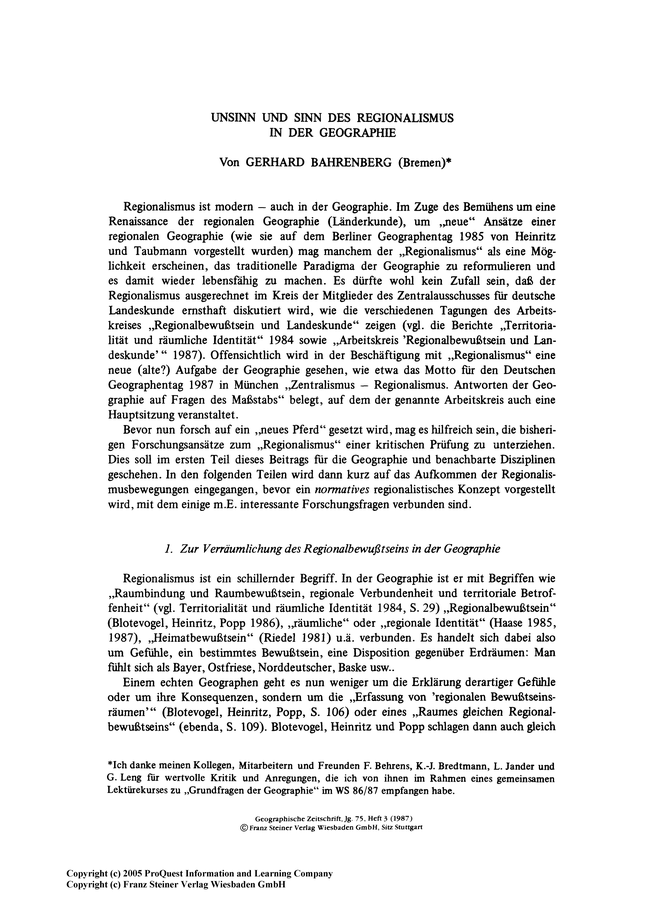

In [ ]:
img = images[0]
img = img.resize((int(img.width * .2), int(img.height * .2)), Image.ANTIALIAS)
img

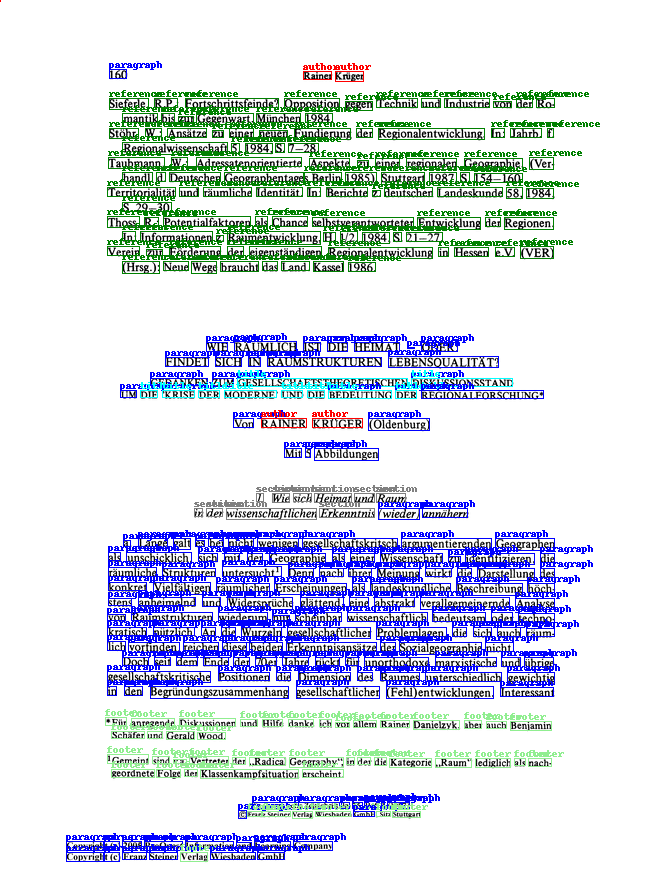

In [ ]:
processed_images[11]

In [ ]:
!pip install -q transformers datasets seqeval sentencepiece

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.3 MB 33.8 MB/s 


In [ ]:
!pip install -q torch==1.10.0+cu111 torchvision==0.11+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
!pip install -q pyyaml==5.1
# workaround: install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9 (issue: https://github.com/facebookresearch/detectron2/issues/3158)
!pip install -q torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install detectron2 that matches pytorch 1.8
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     |████████████████████████████████| 274 kB 34.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.0 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
     |████████████████████████████████| 763.5 MB 14 kB/s 
     |████████████████████████████████| 17.3 MB 41.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.13.1 requires torch==1.12.1, but you have torch 1.8.0+cu101 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.8.0+cu101 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-6pn4uf5_
  

In [ ]:
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch1.10/index.html
#!pip install sentencepiece datasets
#!pip install git+https://github.com/huggingface/transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu113/torch1.10/index.html
     |████████████████████████████████| 7.0 MB 467 kB/s 
     |████████████████████████████████| 130 kB 7.4 MB/s 
     |████████████████████████████████| 79 kB 9.8 MB/s 
     |████████████████████████████████| 151 kB 43.7 MB/s 
     |████████████████████████████████| 50 kB 7.9 MB/s 
     |████████████████████████████████| 843 kB 86.7 MB/s 
     |████████████████████████████████| 117 kB 90.6 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221122-py3-none-any.whl size=61484 sha256=0152ab01aeb27cf752ec21b162b3e8be2ae2b66e340df7b49e94f366b07d3f5c
  Stored in directory: /root/.cache/pip/wheels/2d/e4/d7/be0b4010933f5fffea6385e9b319eac9d6e56c82ee4a0164e5
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=a0ee78a4c0c76d4a9d4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.1 MB/s 
     |████████████████████████████████| 451 kB 96.8 MB/s 
     |████████████████████████████████| 115 kB 89.4 MB/s 
     |████████████████████████████████| 182 kB 92.7 MB/s 
     |████████████████████████████████| 212 kB 92.4 MB/s 
     |████████████████████████████████| 127 kB 78.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-mike5e3w
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-mike5e3w
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel 

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from glob2 import glob

In [ ]:
from transformers import LayoutLMv2Model, LayoutXLMTokenizer, LayoutXLMProcessor

In [ ]:
model = LayoutLMv2Model.from_pretrained("microsoft/layoutxlm-base")
tokenizer = LayoutXLMTokenizer.from_pretrained("microsoft/layoutxlm-base")
processor = LayoutXLMProcessor.from_pretrained("microsoft/layoutxlm-base", revision="no_ocr")

Some weights of the model checkpoint at microsoft/layoutxlm-base were not used when initializing LayoutLMv2Model: ['layoutlmv2.visual.backbone.bottom_up.res2.2.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.0.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res5.2.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.3.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.0.shortcut.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.2.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.0.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.18.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.15.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.0.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.22.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.ba

TypeError: ignored

In [ ]:
path_txt = '/content/txt/*'
header = ['token', 'x0', 'y0', 'x1', 'y1', 'R', 'G', 'B', 'font', 'label']
labels = [
          'abstract',
          'author',
          'caption',
          'date',
          'equation',
          'figure',
          'footer',
          'list',
          'paragraph',
          'reference',
          'section',
          'table',
          'title'
]
id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}

In [ ]:
from PIL import Image
#from transformers import LayoutLMv2Processor
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

#processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")

# we need to define custom features
features = Features({
    'image': Array3D(dtype="int64", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(ClassLabel(names=labels)),
})
#test
def preprocess_data(examples):
  images = [Image.open(path).convert("RGB") for path in examples['image_path']]
  words = examples['words']
  boxes = examples['bboxes']
  word_labels = examples['ner_tags']

  encoded_inputs = processor(images, words, boxes=boxes, word_labels=word_labels,
                             padding="max_length", truncation=True)

  return encoded_inputs

train_dataset = datasets['train'].map(preprocess_data, batched=True, remove_columns=datasets['train'].column_names,
                                      features=features)
test_dataset = datasets['test'].map(preprocess_data, batched=True, remove_columns=datasets['test'].column_names,
                                      features=features)

In [ ]:
for p in glob(path_txt):
    df = pd.read_csv(p, sep='\t', names=header)
    tokens = df.token.values.tolist()
    boxes = df[['x0', 'y0', 'x1', 'y1']].values.tolist()
    tokenized = tokenizer(tokens, boxes=boxes)
    break

In [ ]:
!pip install datasets

     |████████████████████████████████| 312 kB 4.1 MB/s 
     |████████████████████████████████| 212 kB 50.9 MB/s 
     |████████████████████████████████| 1.1 MB 54.8 MB/s 
     |████████████████████████████████| 67 kB 6.7 MB/s 
     |████████████████████████████████| 134 kB 52.2 MB/s 
     |████████████████████████████████| 127 kB 77.7 MB/s 
     |████████████████████████████████| 94 kB 3.1 MB/s 
     |████████████████████████████████| 144 kB 51.3 MB/s 
     |████████████████████████████████| 271 kB 47.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
from datasets import load_dataset

dataset = load_dataset("MrPotato/docbank_small", use_auth_token=True)

Downloading:   0%|          | 0.00/4.67k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset doc_bank downloaded and prepared to /root/.cache/huggingface/datasets/MrPotato___doc_bank/docbank/1.0.0/e7d5930b3807c69b0dd3d77aced2bb2b67441b93c6ba12610bc7b565c05ee91d. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'bboxes', 'token_labels', 'image_path'],
        num_rows: 4500
    })
    test: Dataset({
        features: ['id', 'words', 'bboxes', 'token_labels', 'image_path'],
        num_rows: 500
    })
})

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
len(dataset['train'][10]['token_labels'])

1359

In [ ]:
vocab = tokenizer.get_vocab()
inv_vocab = {v: k for k, v in vocab.items()}

In [ ]:
vocab['▁Heizung']

210611

In [ ]:
inv_vocab[35378]

'▁Hello'

In [ ]:
path_txt_files = '/content/DocBank_500K_txt/'
path_img_files = '/content/DocBank_500K_ori_img/'

In [ ]:
header = ['token', 'x0', 'y0', 'x1', 'y1', 'R', 'G', 'B', 'font', 'label']

In [ ]:
sample_file_list = [
                    '1.tar_1501.00156.gz_1501.00156v2_0', # default starting page
                    '5.tar_1501.02627.gz_paper-arXiv_18', # default reference page
                    '8.tar_1501.04154.gz_FNT_PG_xxx_0', # institutions are labeled as authors
]

In [ ]:
file_cur = sample_file_list[2]

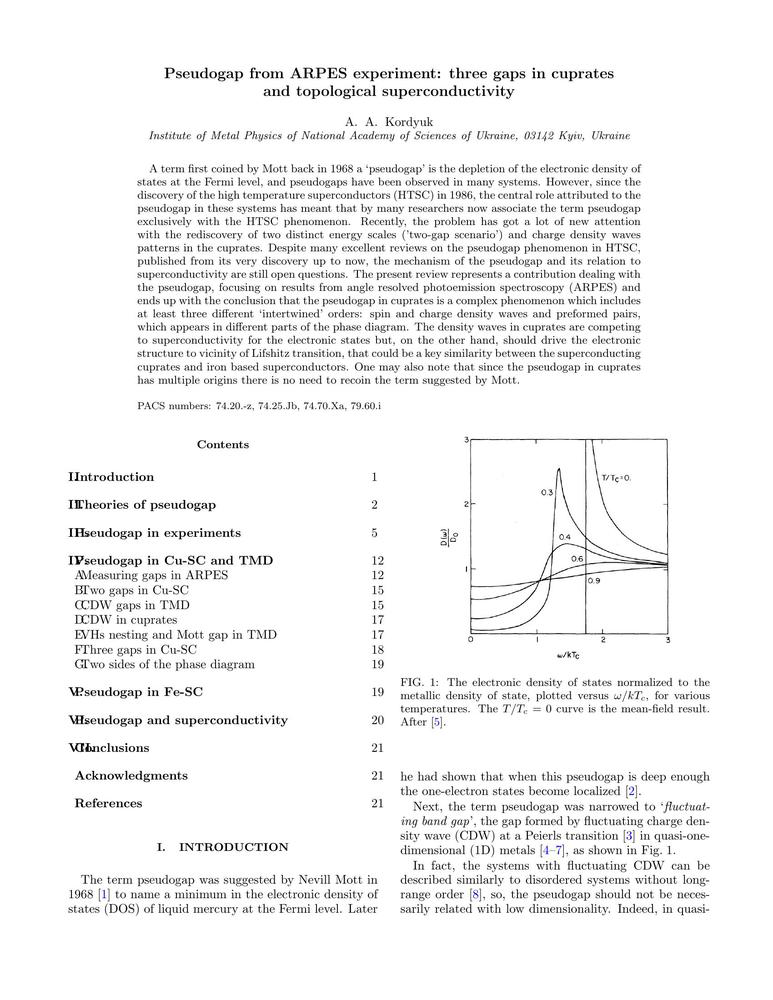

In [ ]:
with PIL.Image.open(path_img_files + file_cur + '_ori.jpg') as im:
    display(im)

In [ ]:
df_txt = pd.read_csv(path_txt_files + file_cur + '.txt', sep='\t', lineterminator='\r', names=header)
df_txt.dropna(how='any', thresh=10, inplace=True)

In [ ]:
df_txt

,token,x0,y0,x1,y1,R,G,B,font,label
0,Pseudogap,212.0,66.0,315.0,81.0,0.0,0.0,0.0,EAPNWJ+CMBX12,title
1,\nfrom,322.0,66.0,367.0,81.0,0.0,0.0,0.0,EAPNWJ+CMBX12,title
2,\nARPES,374.0,66.0,449.0,81.0,0.0,0.0,0.0,EAPNWJ+CMBX12,title
3,\nexperiment:,456.0,66.0,570.0,81.0,0.0,0.0,0.0,EAPNWJ+CMBX12,title
4,\nthree,580.0,66.0,630.0,81.0,0.0,0.0,0.0,EAPNWJ+CMBX12,title
...,...,...,...,...,...,...,...,...,...,...
515,\ndimensionality.,684.0,902.0,790.0,915.0,0.0,0.0,0.0,KWKGIK+CMR10,paragraph
516,"\nIndeed,",799.0,902.0,851.0,915.0,0.0,0.0,0.0,KWKGIK+CMR10,paragraph
517,\nin,856.0,902.0,870.0,915.0,0.0,0.0,0.0,KWKGIK+CMR10,paragraph
518,\nquasi-,876.0,902.0,918.0,915.0,0.0,0.0,0.0,KWKGIK+CMR10,paragraph


In [ ]:
alpha = 0.3
alpha_val = int(256 * alpha)
label2col = {
          'abstract': (89, 217, 9, alpha_val),
          'author': (28, 22, 224, alpha_val),
          'caption': (224, 222, 22, alpha_val),
          'date': (224, 22, 213, alpha_val),
          'equation': (173, 87, 5, alpha_val),
          'figure': (113, 44, 197, alpha_val),
          'footer': (64, 48, 33, alpha_val),
          'list': (164, 217, 206, alpha_val),
          'paragraph': (30, 30, 29, alpha_val),
          'reference': (64, 48, 33, alpha_val),
          'section': (240, 126, 158, alpha_val),
          'table': (164, 178, 55, alpha_val),
          'title': (255, 0, 0, alpha_val)
}

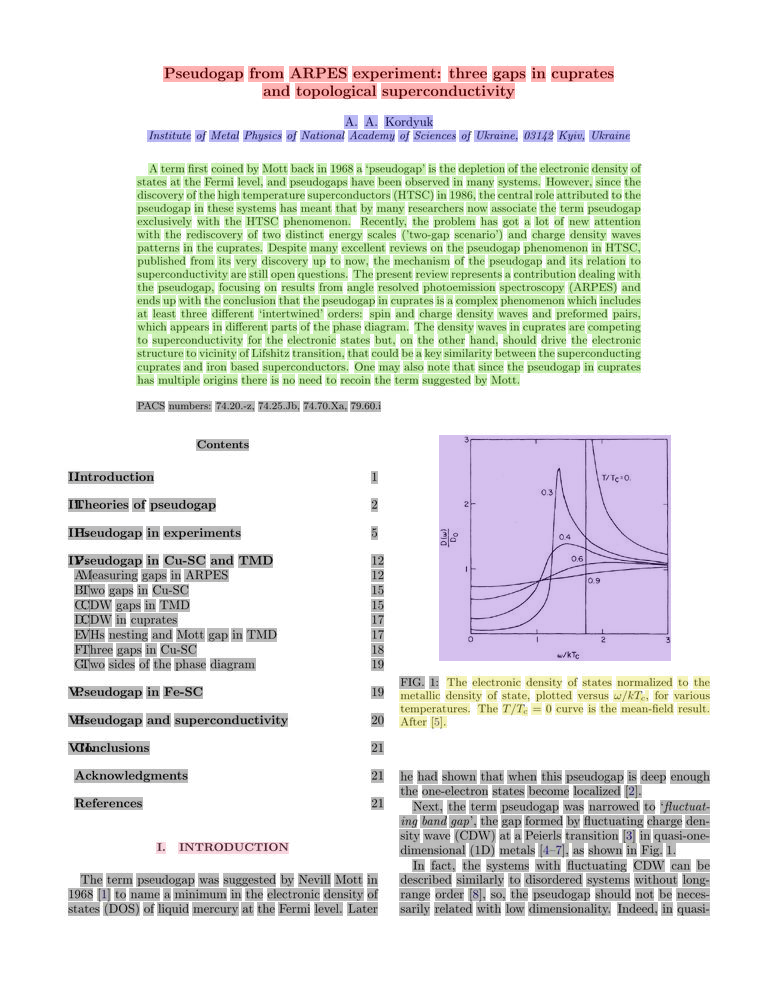

In [ ]:
with PIL.Image.open(path_img_files + file_cur + '_ori.jpg') as im:
    #im = im.convert("RGBA")
    h, w = im.size
    for i, r in df_txt.iterrows():
        shape = [(r['x0'] * h/w, r['y0']), (r['x1'] * h/w, r['y1'])]
        im_draw = ImageDraw.Draw(im, 'RGBA')
        col = label2col[r.label]
        im_draw.rectangle(shape, fill=col)
    display(im)

In [ ]:
files_txt =  glob('/content/txt/*')

In [ ]:
np.random.seed = 33

In [ ]:
random_selected = np.random.choice(files_txt, size=500, replace=False)

In [ ]:
train_txt = [p for p in files_txt if p not in random_selected]

In [ ]:
train_img = [p.replace('.txt', '_ori.jpg').replace('/content/txt/', '/content/img/') for p in train_txt]

In [ ]:
test_txt = [p for p in random_selected]

In [ ]:
test_img = [p.replace('.txt', '_ori.jpg').replace('/content/txt/', '/content/img/') for p in test_txt]

In [ ]:
import zipfile
from os.path import basename

In [ ]:
with zipfile.ZipFile("dataset.zip", "w") as zf:
    for p in train_txt:
        zf.write(p, 'train\\txt\\' + basename(p), compress_type=zipfile.ZIP_DEFLATED)
    for p in train_img:
        zf.write(p, 'train\\img\\' + basename(p), compress_type=zipfile.ZIP_DEFLATED)
    for p in test_txt:
        zf.write(p, 'test\\txt\\' + basename(p), compress_type=zipfile.ZIP_DEFLATED)
    for p in test_img:
        zf.write(p, 'test\\img\\' + basename(p), compress_type=zipfile.ZIP_DEFLATED)

In [ ]:
p

'/content/txt/102.tar_1408.2602.gz_laine_22.txt'

In [ ]:
!cp /content/dataset.zip /gdrive/MyDrive/Uni/Masterarbeit/Data/docbank/dataset.zip

In [ ]:
processed_images[0].save(r'images.pdf', save_all=True, append_images=processed_images[1:])